### Example of PINN with 1D oscillatior.
This is an example of PINN and its application to simple physical use case. <br>
In a nutshell, PINN takes equations in the loss as physical constraint to the training of neural network, which increases the physical awareness of the neural network.

Here is a nice blog post about this topic: <br>
https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/

This notebook is inspired by the following work:
https://github.com/benmoseley/harmonic-oscillator-pinn

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.manual_seed(1)

#### Definition of a 1D underdamped harmonic oscillator
Here we write down the mathematical expression of the oscillator and obtain the analytical solution of it.

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$

We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

In [2]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

Just for comparison, we define a simple multi layer percepton network to learn the oscillator.

In [3]:
class MLP(nn.Module):
    """Define a Multi Layer Percepton network to learn oscillator."""

    def __init__(self, input, output, hidden, layers):
        super().__init__()
        activation = nn.Tanh #nn.ReLU
        self.input = nn.Sequential(*[nn.Linear(input, hidden), activation()])
        self.hidden = nn.Sequential(*[
            nn.Sequential(*[nn.Linear(hidden, hidden), activation()])
            for _ in range(layers)
        ])
        self.output = nn.Linear(hidden, output)

    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)

        return x

Now we generate both the training and testing data using the oscillator function.

In [4]:
# define constant of system
d = 2
w0 = 20

# get analytical solutions over time
x = torch.linspace(0, 1, 500).view(-1, 1)
y = oscillator(d, w0, x).view(-1, 1)
print(x.shape, y.shape)

torch.Size([500, 1]) torch.Size([500, 1])


torch.Size([10, 1]) torch.Size([10, 1])


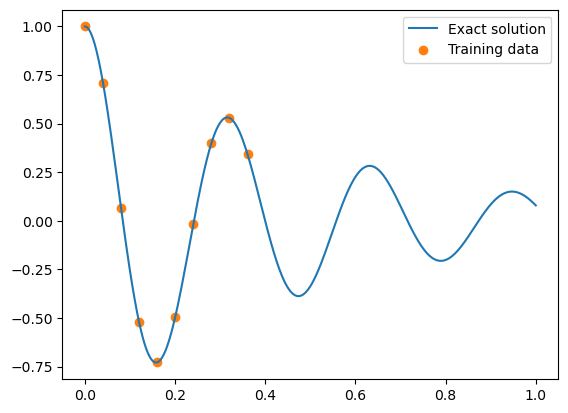

In [5]:
# check the training data
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

In [6]:
# train network
model = MLP(1, 1, 32, 3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
# Specify loss function
criterion = nn.MSELoss()

for i in range(1000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = criterion(yh, y_data)
    #loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()

In [7]:
print(model)

MLP(
  (input): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
  )
  (hidden): Sequential(
    (0): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
    )
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


In [8]:
def fancy_plot(x,y,x_data,y_data,yh,xp=None):
    """Fancy plot for training results."""
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")


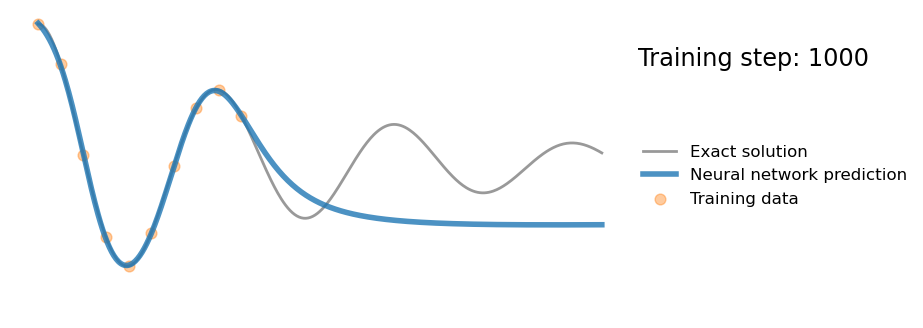

In [9]:
# plot training results
yh = model(x).detach()
fancy_plot(x,y,x_data,y_data,yh)

### PINN
Now we will implement PINN by adding differential equations to the loss function, to unlock the potential of the so-called physics-informed network.

This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

Here we evaluate the physics loss at 30 points uniformly spaced over the problem domain. 

We can calculate the derivatives of the network solution with respect to its input variable at these points using pytorch's autodifferentiation (following chain-rule of derivatives) features, and can then easily compute the residual of the differential equation using these quantities.

In [10]:
# sample locations over the problem domain
x_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)
# some constants
mu = 2*d
k = w0**2

torch.manual_seed(123)
model = MLP(1,1,32,3)
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.MSELoss()

In [11]:
for i in range(20000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(x_data)
    #loss1 = torch.mean((yh-y_data)**2)
    loss1 = criterion(yh, y_data)
    
    # compute the "physics loss"
    yhp = model(x_physics)
    # computes dy/dx
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
    # computes d^2y/dx^2
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]
    # computes the residual of the 1D harmonic oscillator differential equation
    physics = dx2 + mu*dx + k*yhp
    loss2 = learning_rate * torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()

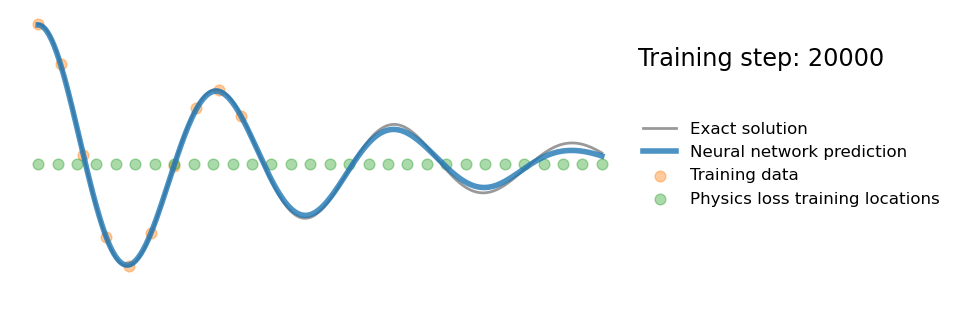

In [12]:
# plot the results of PINN
yh = model(x).detach()
xp = x_physics.detach()

fancy_plot(x,y,x_data,y_data,yh,xp)